# Twitch Streamer Success Analysis

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
data = pd.read_csv('data/twitch-data-all.csv')
data = data.dropna()

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 788 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   channel              788 non-null    object 
 1   watch_time_minutes   788 non-null    int64  
 2   stream_time_minutes  788 non-null    int64  
 3   peak_viewers         788 non-null    int64  
 4   average_viewers      788 non-null    int64  
 5   followers            788 non-null    int64  
 6   followers_gained     788 non-null    int64  
 7   views_gained         788 non-null    int64  
 8   partnered            788 non-null    bool   
 9   mature               788 non-null    bool   
 10  language             788 non-null    object 
 11  ranking              788 non-null    float64
 12  earnings_usd         788 non-null    float64
dtypes: bool(2), float64(2), int64(7), object(2)
memory usage: 75.4+ KB


## Correlation with Earnings

In [94]:
metrics = [
    'watch_time_minutes', 
    'stream_time_minutes', 
    'peak_viewers', 
    'average_viewers', 
    'followers'
]

correlation_results = {}
for metric in metrics:
    correlation_results[metric] = data[metric].corr(data['earnings_usd'], method='spearman')

# Sort correlations
sorted_correlations = sorted(
    correlation_results.items(), 
    key=lambda x: abs(x[1]), reverse=True
    )


In [95]:
sorted_correlations

[('watch_time_minutes', np.float64(0.47118545445342014)),
 ('followers', np.float64(0.34287021170706533)),
 ('average_viewers', np.float64(0.31782946283013336)),
 ('peak_viewers', np.float64(0.2761893947689601)),
 ('stream_time_minutes', np.float64(0.13446399058056213))]

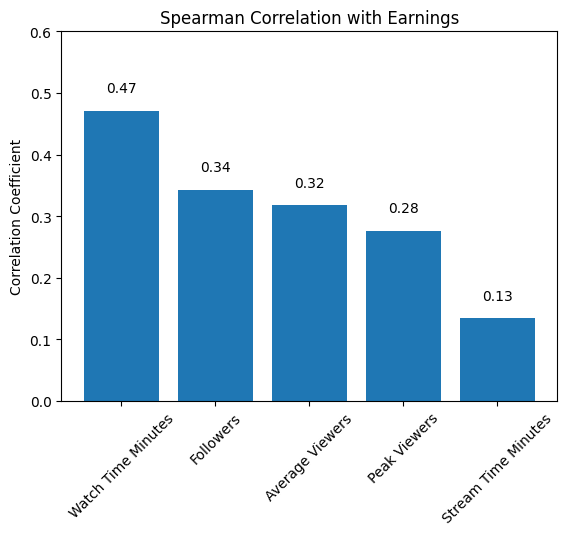

In [96]:
plt.bar(range(len(sorted_correlations)), [x[1] for x in sorted_correlations])
plt.xticks(
    range(len(sorted_correlations)), 
    [x[0].replace('_', ' ').title() for x in sorted_correlations], 
    rotation=45
    )
plt.ylabel('Correlation Coefficient')
plt.title('Spearman Correlation with Earnings')
plt.ylim(0, 0.6)

for i, v in enumerate([x[1] for x in sorted_correlations]):
    plt.text(i, v + 0.03, f'{v:.2f}', ha='center')

## Scatterplot top metrics vs earnings

Text(0.5, 1.0, 'Earnings vs. Watch Time')

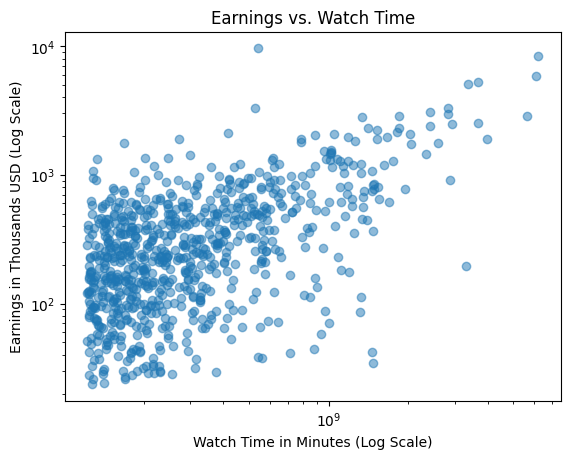

In [97]:
plt.scatter(data['watch_time_minutes'], data['earnings_usd'] / 1000, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Watch Time in Minutes (Log Scale)')
plt.ylabel('Earnings in Thousands USD (Log Scale)')
plt.title('Earnings vs. Watch Time')

Text(0.5, 1.0, 'Earnings vs. Followers')

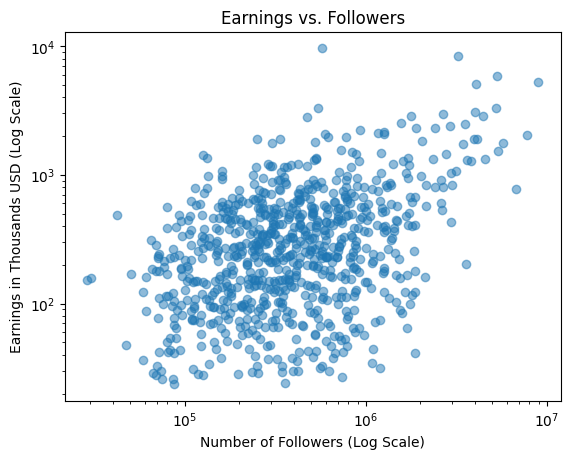

In [98]:
plt.scatter(data['followers'], data['earnings_usd'] / 1000, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Followers (Log Scale)')
plt.ylabel('Earnings in Thousands USD (Log Scale)')
plt.title('Earnings vs. Followers')

Text(0.5, 1.0, 'Earnings vs. Average Viewers')

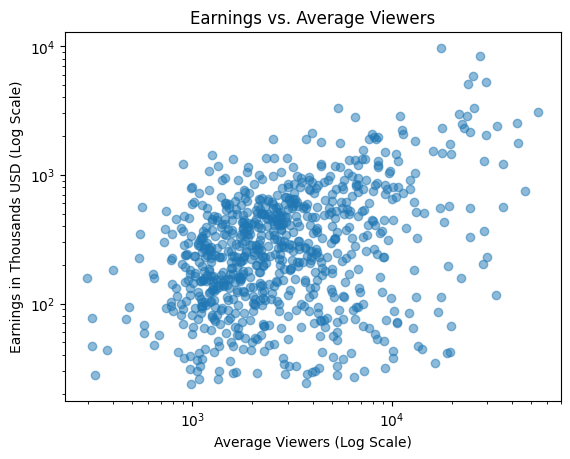

In [99]:
plt.scatter(data['average_viewers'], data['earnings_usd'] / 1000, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Average Viewers (Log Scale)')
plt.ylabel('Earnings in Thousands USD (Log Scale)')
plt.title('Earnings vs. Average Viewers')

## Earnings by Average Viewers

In [100]:
data['average_viewers'].min()

np.int64(297)

In [101]:
viewership_bins = [100, 500, 1000, 5000, 10000, float('inf')]
data['viewer_bracket'] = pd.cut(
        data['average_viewers'], 
        viewership_bins, 
        labels=['100-500', '500-1000', '1000-5000', '5000-10000', '10000+']
    )

earnings_by_viewers = data.groupby('viewer_bracket', observed=True)['earnings_usd'].agg(['mean', 'count'])
earnings_by_viewers['mean'] = earnings_by_viewers['mean'] / 1000  # Convert to thousands for readability

In [102]:
earnings_by_viewers

,mean,count
viewer_bracket,,
100-500,88.452758,8
500-1000,240.562171,57
1000-5000,332.793297,529
5000-10000,597.526188,121
10000+,1374.638303,73


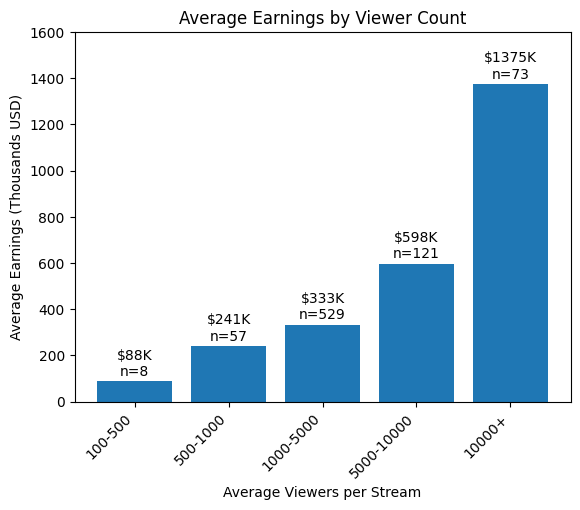

In [103]:
plt.bar(range(len(earnings_by_viewers)), earnings_by_viewers['mean'])
plt.xticks(range(len(earnings_by_viewers)), earnings_by_viewers.index, rotation=45, ha='right')
plt.title('Average Earnings by Viewer Count')
plt.xlabel('Average Viewers per Stream')
plt.ylabel('Average Earnings (Thousands USD)')
plt.ylim(0, 1600)

for i, v in enumerate(earnings_by_viewers['mean']):
    plt.text(i, v + 25, f'${v:.0f}K\nn={earnings_by_viewers["count"].iloc[i]}', ha='center')

## Earnings by Languages

In [104]:
language_stats = data.groupby('language').agg({
    'earnings_usd': 'mean',
    'channel': 'count',
    'average_viewers': 'mean'
}).rename(columns={'channel': 'streamer_count'}).sort_values('streamer_count', ascending=False)
language_stats['earnings_per_viewer'] = language_stats['earnings_usd'] / language_stats['average_viewers']

top_languages = language_stats.head(10).copy()
top_languages['earnings_usd'] = round(top_languages['earnings_usd'] / 1000, 2)  # Convert to thousands
top_languages['earnings_per_viewer'] = round(top_languages['earnings_per_viewer'], 2)
top_languages['average_viewers'] = round(top_languages['average_viewers'])

In [105]:
top_languages
# language_stats

,earnings_usd,streamer_count,average_viewers,earnings_per_viewer
language,,,,
English,581.37,445,4622.0,125.78
French,342.21,63,3543.0,96.59
Spanish,357.71,61,6745.0,53.03
Portuguese,286.80,52,3711.0,77.28
German,514.36,47,4351.0,118.21
Russian,79.10,38,5433.0,14.56
Turkish,148.28,19,4804.0,30.87
Italian,447.86,16,2264.0,197.83
Polish,138.55,11,2652.0,52.25


In [106]:
# define color mappings for top languages
language_colors = {
    'English': '#1f77b4',
    'Korean': '#ff7f0e',
    'Russian': '#2ca02c',
    'Spanish': '#d62728',
    'French': '#9467bd',
    'Portuguese': '#8c564b',
    'German': '#e377c2',
    'Chinese': '#7f7f7f',
    'Turkish': '#bcbd22',
    'Italian': '#17becf',
    'Polish': '#aec7e8',
    'Thai': '#ffbb78'
    }

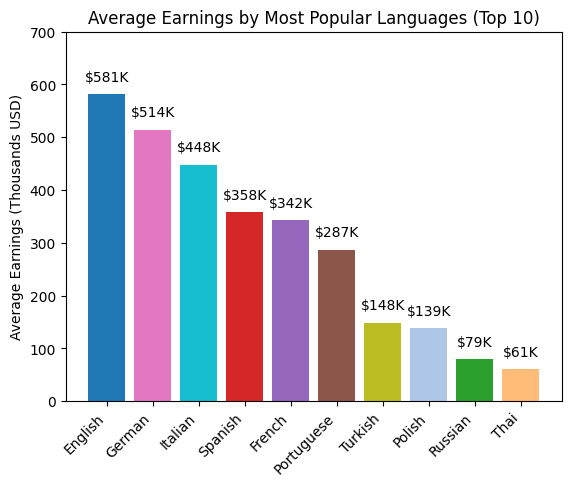

In [107]:
top_languages = top_languages.sort_values('earnings_usd', ascending=False)
# Extract the colors in the same order as top_languages
colors = [language_colors.get(lang, '#333333') for lang in top_languages.index]

plt.bar(range(len(top_languages)), top_languages['earnings_usd'], color=colors)
plt.xticks(range(len(top_languages)), top_languages.index, rotation=45, ha='right')
plt.title('Average Earnings by Most Popular Languages (Top 10)')
plt.ylabel('Average Earnings (Thousands USD)')
plt.ylim(0, 700)

for i, v in enumerate(top_languages['earnings_usd']):
    plt.text(i, v + 25, f'${v:.0f}K', ha='center')

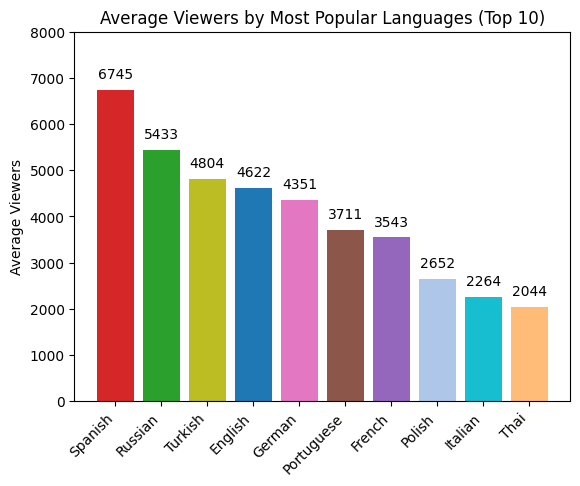

In [108]:
top_languages = top_languages.sort_values('average_viewers', ascending=False)
# Extract the colors in the same order as top_languages
colors = [language_colors.get(lang, '#333333') for lang in top_languages.index]

plt.bar(range(len(top_languages)), top_languages['average_viewers'], color=colors)
plt.xticks(range(len(top_languages)), top_languages.index, rotation=45, ha='right')
plt.title('Average Viewers by Most Popular Languages (Top 10)')
plt.ylabel('Average Viewers')
plt.ylim(0, 8000)

for i, v in enumerate(top_languages['average_viewers']):
    plt.text(i, v + 250, f'{v:.0f}', ha='center')

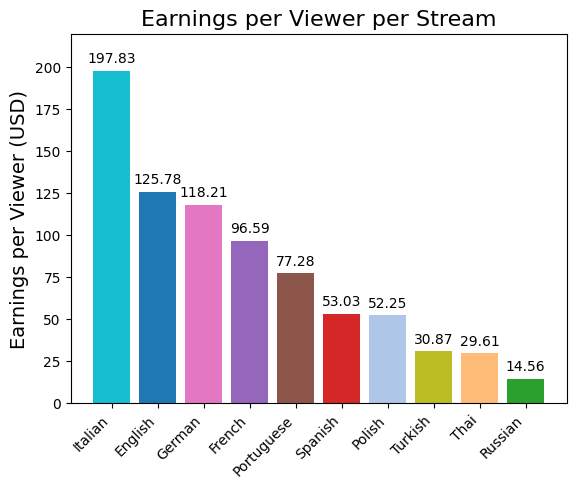

In [109]:
top_languages = top_languages.sort_values('earnings_per_viewer', ascending=False)
# Extract the colors in the same order as top_languages
colors = [language_colors.get(lang, '#333333') for lang in top_languages.index]

# plt.figure(figsize=(10, 8))
# ax = sns.barplot(
#     x='language', 
#     y='earnings_per_viewer', 
#     data=top_languages,
#     palette='viridis'
# )

plt.bar(range(len(top_languages)), top_languages['earnings_per_viewer'], color=colors)
plt.title('Earnings per Viewer per Stream', fontsize=16)
# plt.xlabel('Language', fontsize=14)
plt.ylabel('Earnings per Viewer (USD)', fontsize=14)
# plt.xticks(rotation=45, ha='right')
plt.xticks(range(len(top_languages)), top_languages.index, rotation=45, ha='right')
plt.ylim(0, 220)

for i, v in enumerate(top_languages['earnings_per_viewer']):
    plt.text(i, v + 5, f'{v:.2f}', ha='center')

Although Spanish language channels have the most views, they only rank fourth in terms of earnings. Similarly, russian channels rank second for average viewers but ninth in average earnings. 

English, German, and Italian channels seem to have the best ratio of earnings per viewer.

## Partnered vs Non-Partnered Earnings

* Being a Twitch partner means that you have access to Twitch's built-in monetization options such as subscriptions, bits, and ad revenue sharing. 
* Non-partnered channes can still make money through other means, either by being an 'Affiliate', or donations, sponsorships, subscriptions outside of twitch.

In [110]:
partner_stats = data.groupby('partnered')['earnings_usd'].agg(['mean', 'count'])
partner_stats['mean'] = partner_stats['mean'] / 1000  # Convert to thousands

In [111]:
partner_stats

,mean,count
partnered,,
False,115.696676,7
True,463.901035,781


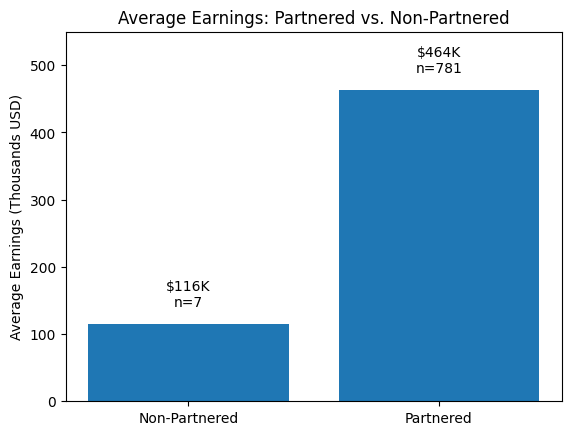

In [112]:
partner_labels = ['Non-Partnered', 'Partnered']
plt.bar(range(len(partner_stats)), partner_stats['mean'])
plt.xticks(range(len(partner_stats)), partner_labels)
plt.title('Average Earnings: Partnered vs. Non-Partnered')
plt.ylabel('Average Earnings (Thousands USD)')
plt.ylim(0, 550)

for i, v in enumerate(partner_stats['mean']):
    plt.text(i, v + 25, f'${v:.0f}K\nn={partner_stats["count"].iloc[i]}', ha='center')

## Stream time analysis

In [120]:
stream_time_bins = [5000, 10000, 20000, 50000, 100000, float('inf')]
data['stream_time_bracket'] = pd.cut(data['stream_time_minutes'], stream_time_bins, 
                                   labels=['5K-10K', '10K-20K', '20K-50K', '50K-100K', '100K+'])

stream_time_stats = data.groupby('stream_time_bracket', observed=True)['earnings_usd'].agg(['mean', 'count'])
stream_time_stats['mean'] = stream_time_stats['mean'] / 1000  # Convert to thousands

In [114]:
stream_time_stats

,mean,count
stream_time_bracket,,
5K-10K,41.409010,1
10K-20K,158.004320,15
20K-50K,466.056739,65
50K-100K,410.115319,254
100K+,499.430755,453


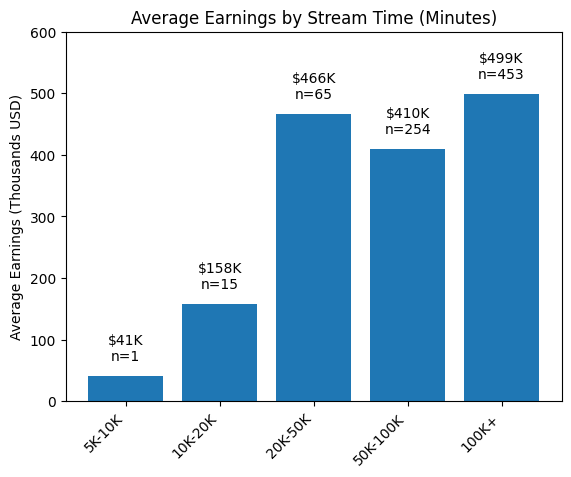

In [115]:
plt.bar(range(len(stream_time_stats)), stream_time_stats['mean'])
plt.xticks(range(len(stream_time_stats)), stream_time_stats.index, rotation=45, ha='right')
plt.title('Average Earnings by Stream Time (Minutes)')
plt.ylabel('Average Earnings (Thousands USD)')
plt.ylim(0, 600)

for i, v in enumerate(stream_time_stats['mean']):
    plt.text(i, v + 25, f'${v:.0f}K\nn={stream_time_stats["count"].iloc[i]}', ha='center')

While stream time did not strongly correlate strongly with earnings, it is possible that streaming too little does impact earnings. Recommended streaming at least 20-50k minutes per year to reach the plateau in earnings.

## Mature vs Non-mature content

In [117]:
mature_stats = data.groupby('mature')['earnings_usd'].agg(['mean', 'count'])
mature_stats['mean'] = mature_stats['mean'] / 1000  # Convert to thousands

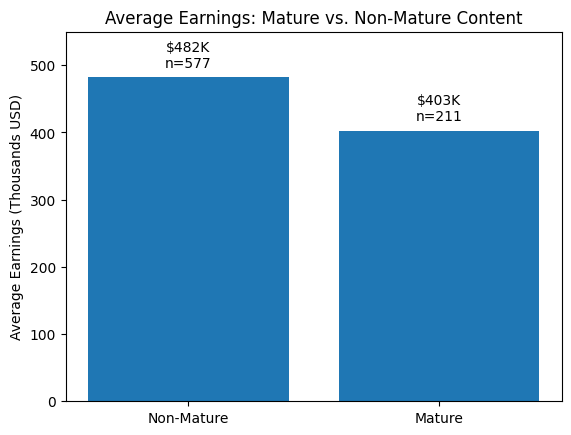

In [118]:
mature_labels = ['Non-Mature', 'Mature']
plt.bar(range(len(mature_stats)), mature_stats['mean'])
plt.xticks(range(len(mature_stats)), mature_labels)
plt.title('Average Earnings: Mature vs. Non-Mature Content')
plt.ylabel('Average Earnings (Thousands USD)')
plt.ylim(0, 550)

for i, v in enumerate(mature_stats['mean']):
    plt.text(i, v + 15, f'${v:.0f}K\nn={mature_stats["count"].iloc[i]}', ha='center')
